# Deep Learning with PyTorch




### Building a simple neural network

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

from torch.autograd import Variable
from sklearn.datasets import load_iris

# Custom DataSet
from data import iris

### The Dataset and the challenge

![iris](data/iris.jpg)

The **Iris** flower, image source: [Wikimedia](https://en.wikipedia.org/wiki/Iris_(plant))


| sepal_length_cm | sepal_width_cm | petal_length_cm | petal_width_cm | class           |
|-----------------|----------------|-----------------|----------------|-----------------|
| 5.1             | 3.5            | 1.4             | 0.2            | Iris-setosa     |
| 7.0             | 3.2            | 4.7             | 1.4            | Iris-versicolor |
| 6.3             | 3.3            | 6.0             | 2.5            | Iris-virginica  |


* Total instances: 150 (we have separated 20% into validation set, rest into training set)
* Download: [Data Source](https://archive.ics.uci.edu/ml/datasets/iris)

### Let's do a head on the raw file

In [2]:
!head data/iris.data.txt


sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa


### Create the Fully Connected Feed Forward Neural Network

**Create the module**

In [3]:
#Set up the Neural Network
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

**Print the module**

In [4]:
# Neural Network model params and NN connections
model = IrisNet(4, 100, 50, 3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


### Our Neural Network looks like this
![](pynb_pics/pytorch_NN.jpg)

### Create the DataLoader

In [5]:
batch_size = 60 # Training in batches of 60 samples.  Saves memory and computing resources for large datasets
# BUT the smaller the batch the less accurate the estimate of the gradient will be !
iris_data_file = 'data/iris.data.txt'
#iris_data_file  = load_iris()

In [6]:
# Get the datasets - default 80/20 split
train_ds, test_ds = iris.get_datasets(iris_data_file)


# How many instances have we got?
print('# instances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))

# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

# instances in training set:  120
# instances in testing/validation set:  30


### Instantiate the network, the loss function and the optimizer

In [7]:
# Our model
net = IrisNet(4, 100, 50, 3)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)  

### Train it!

In [8]:
num_epochs = 50 # These are the iterations

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        # print(classes)
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        train_total += classes.size(0)    
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
#              %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.data[0]))
               %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.item()))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss
#    train_loss.append(loss.data[0])
    train_loss.append(loss.item())

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_ds.data.values[:, 0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:, 4])

    outputs = net(Variable(test_items))
    loss = criterion(outputs, Variable(test_classes))
#    test_loss.append(loss.data[0])
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/50, Iteration 1/2, Loss: 1.1543
Epoch 1/50, Iteration 2/2, Loss: 1.1779
Epoch 2/50, Iteration 1/2, Loss: 1.1143
Epoch 2/50, Iteration 2/2, Loss: 1.1506
Epoch 3/50, Iteration 1/2, Loss: 1.0945
Epoch 3/50, Iteration 2/2, Loss: 1.0900
Epoch 4/50, Iteration 1/2, Loss: 1.0575
Epoch 4/50, Iteration 2/2, Loss: 1.0565
Epoch 5/50, Iteration 1/2, Loss: 1.0255
Epoch 5/50, Iteration 2/2, Loss: 1.0597
Epoch 6/50, Iteration 1/2, Loss: 1.0390
Epoch 6/50, Iteration 2/2, Loss: 1.0120
Epoch 7/50, Iteration 1/2, Loss: 1.0424
Epoch 7/50, Iteration 2/2, Loss: 0.9871
Epoch 8/50, Iteration 1/2, Loss: 1.0047
Epoch 8/50, Iteration 2/2, Loss: 1.0033
Epoch 9/50, Iteration 1/2, Loss: 0.9983
Epoch 9/50, Iteration 2/2, Loss: 0.9821
Epoch 10/50, Iteration 1/2, Loss: 0.9833
Epoch 10/50, Iteration 2/2, Loss: 0.9696
Epoch 11/50, Iteration 1/2, Loss: 0.9689
Epoch 11/50, Iteration 2/2, Loss: 0.9461
Epoch 12/50, Iteration 1/2, Loss: 0.9348
Epoch 12/50, Iteration 2/2, Loss: 0.9492
Epoch 13/50, Iteration 1/2, Loss: 

Plot loss vs iterations

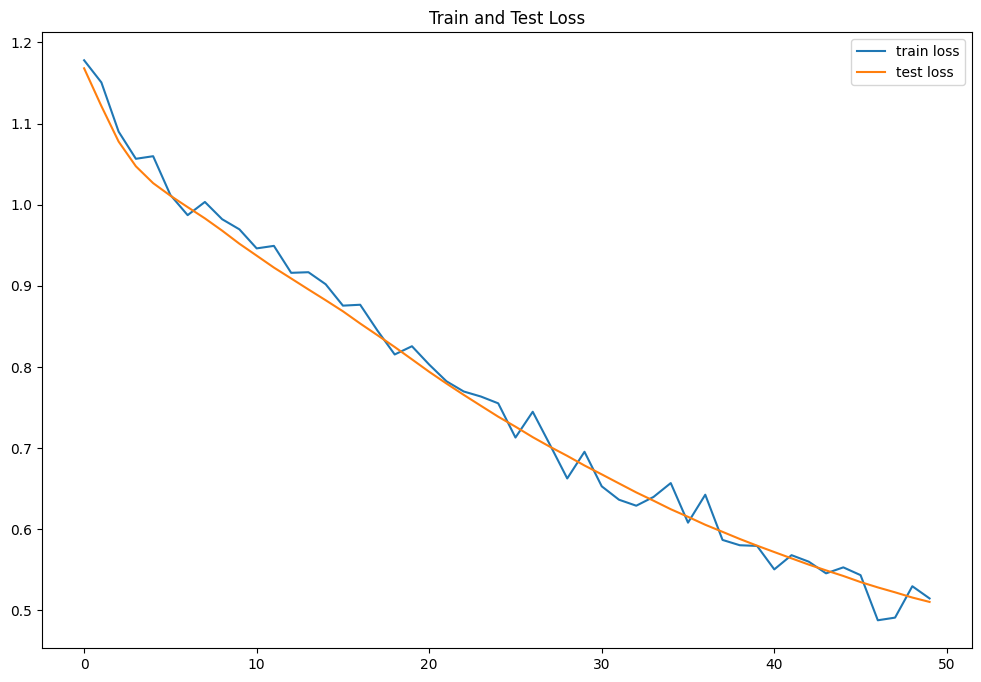

In [9]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

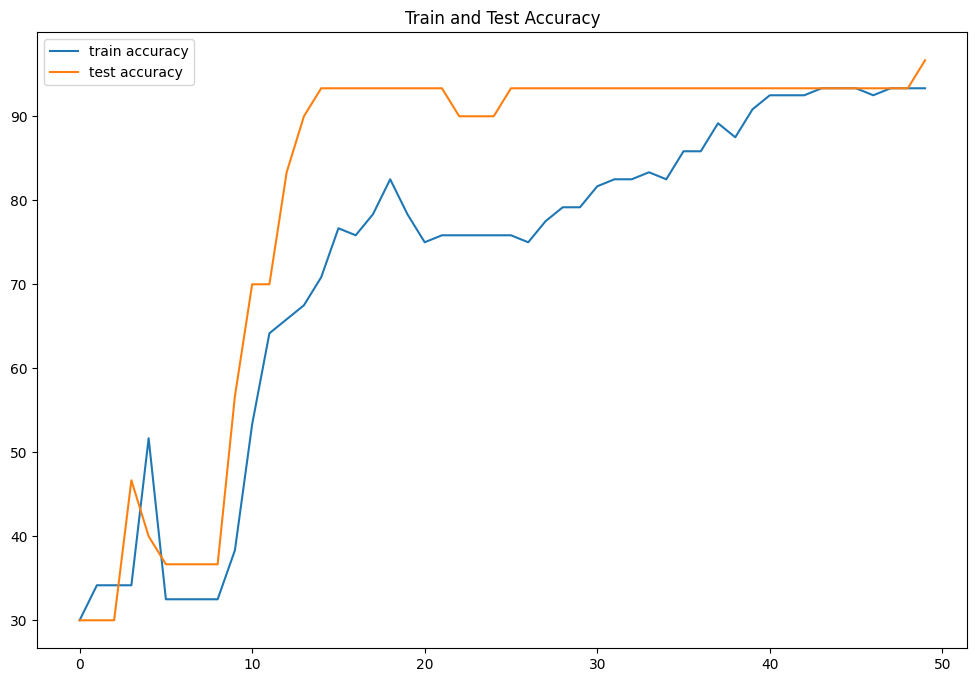

In [10]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

Our model is reaching about 95% accuracy.  That's very good

### Saving the model to disk, and loading it back

In [11]:
torch.save(net.state_dict(), "./2.model.pth")

In [12]:
net2 = IrisNet(4, 100, 50, 3)
net2.load_state_dict(torch.load("./2.model.pth"))

<All keys matched successfully>

In [13]:
# output = net2(Variable(torch.FloatTensor([[5.1, 3.5, 1.4, 0.2]]))) # Iris-setosa
output = net2(Variable(torch.FloatTensor([[7.0, 3.2, 4.7, 1.4]]))) # Iris-versicolor
#output = net2(Variable(torch.FloatTensor([[6.3, 3.3, 6.0, 2.5]])))  # Iris-virginica


### Test

In [14]:
_, predicted_class = torch.max(output.data, 1)

print('Predicted class: ', predicted_class.numpy()[0])
print('0: Iris-setosa ')
print('1: Iris-versicolor ')
print('2: Iris-virginica ')

Predicted class:  1
0: Iris-setosa 
1: Iris-versicolor 
2: Iris-virginica 


Prediction is correct